# Week 2: Feature Exploration
### Goal: Compute rolling stats, moving averages, and basic features for trading/AI models

In [1]:
# Imports & Helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import yfinance as yf
from datetime import datetime, date

plt.rcParams['figure.dpi'] = 120  # make plots look nicer in notebooks

def load_btc_csv(data_dir="../data", load_latest=True, specific_file=None):
    """
    Load BTC CSV from the specified folder, with robust date parsing
    and numeric 'Price' column for backtesting.
    
    Parameters
    ----------
    data_dir : str
        Folder where BTC CSVs are stored.
    load_latest : bool
        If True and specific_file=None, load the most recently saved CSV.
    specific_file : str or Path
        If provided, load this specific CSV for reproducibility.

    Returns
    -------
    pd.DataFrame
        BTC data with datetime index and numeric 'Price' column.
    """
    # Determine file to load
    if specific_file is not None:
        csv_path = Path(specific_file)
    elif load_latest:
        files = glob.glob(f"{data_dir}/btc_*.csv")
        if not files:
            raise FileNotFoundError(f"No BTC CSV files found in {data_dir}")
        csv_path = Path(max(files, key=lambda f: Path(f).stat().st_mtime))
    else:
        raise ValueError("No CSV specified and load_latest is False.")

    # Load CSV
    df = pd.read_csv(csv_path, index_col=0)

    # Ensure index is datetime
    df.index = pd.to_datetime(df.index, errors='coerce', format="%Y-%m-%d")

    # Optional: drop rows where 'Close' is NaN
    df = df.dropna(subset=['Close'])

    # Ensure 'Price' exists
    if 'Price' not in df.columns:
        df['Price'] = df['Close']

    # Convert 'Price' to numeric, drop any rows that failed
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna(subset=['Price'])

    # Print info
    print(f"Loaded BTC data from: {csv_path}")
    print(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Number of rows: {len(df)}")

    return df

In [2]:
# Load latest CSV automatically
btc = load_btc_csv()

# OR, load a specific past CSV for reproducibility
# btc = load_btc_csv(specific_file="../data/btc_2025-09-13.csv")

Loaded BTC data from: ..\data\btc_2025-09-13.csv
Date range: 2020-01-01 to 2025-09-12
Number of rows: 2082


### BTC Moving Average (MA) Strategy
Goal: Implement a simple MA crossover trading strategy and backtest it vs buy-and-hold

Sharpe Ratio of MA strategy: 0.86


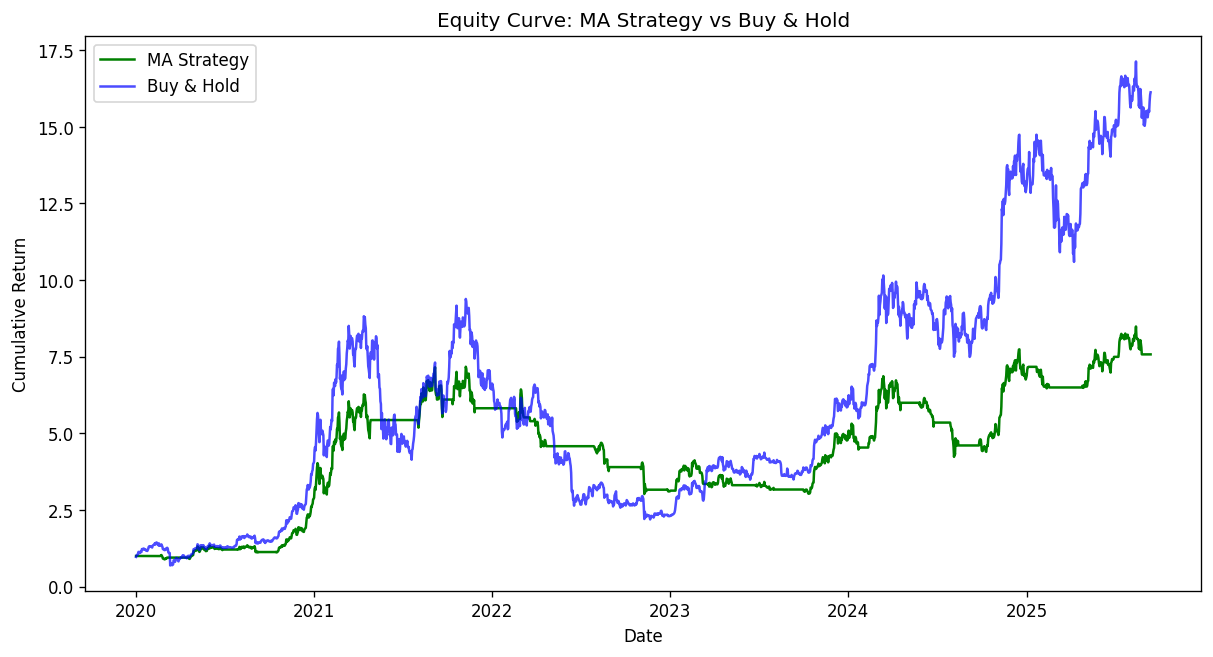

In [3]:
# Compute moving averages on 'Price'
# -------------------------------
short_window = 20  # short-term MA
long_window = 50   # long-term MA

btc['MA_short'] = btc['Price'].rolling(window=short_window).mean()
btc['MA_long'] = btc['Price'].rolling(window=long_window).mean()

# -------------------------------
# Generate signals safely (1=Buy, 0=Sell)
# -------------------------------
btc['Signal'] = 0
btc.loc[btc.index[short_window:], 'Signal'] = np.where(
    btc['MA_short'][short_window:] > btc['MA_long'][short_window:], 1, 0
)

# Compute daily strategy returns
btc['Strategy Return'] = btc['Signal'].shift(1) * btc['Price'].pct_change()

# Buy-and-hold returns
btc['BuyHold Return'] = btc['Price'].pct_change()

# -------------------------------
# Backtest metrics
# -------------------------------
def compute_sharpe(returns, annual_factor=252):
    """
    Compute annualized Sharpe ratio.
    """
    mean = returns.mean() * annual_factor
    std = returns.std() * np.sqrt(annual_factor)
    return mean / std if std != 0 else np.nan

btc['Cumulative Strategy'] = (1 + btc['Strategy Return']).cumprod()
btc['Cumulative BuyHold'] = (1 + btc['BuyHold Return']).cumprod()

sharpe_ratio = compute_sharpe(btc['Strategy Return'].dropna())
print(f"Sharpe Ratio of MA strategy: {sharpe_ratio:.2f}")

# -------------------------------
# Plot equity curves
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(btc['Cumulative Strategy'], label='MA Strategy', color='green')
plt.plot(btc['Cumulative BuyHold'], label='Buy & Hold', color='blue', alpha=0.7)
plt.title("Equity Curve: MA Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [4]:
# Print summary metrics
print(f"Sharpe Ratio of MA strategy: {sharpe_ratio:.2f}")
print(f"Final cumulative return (strategy): {btc['Cumulative Strategy'].iloc[-1]:.2f}")
print(f"Final cumulative return (buy & hold): {btc['Cumulative BuyHold'].iloc[-1]:.2f}")

Sharpe Ratio of MA strategy: 0.86
Final cumulative return (strategy): 7.58
Final cumulative return (buy & hold): 16.12


## Conclusion
- The MA strategy can reduce drawdowns compared to buy-and-hold
- Sharpe ratio indicates risk-adjusted performance
- Results depend on MA window parameters (20/50 here)